In [32]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
from scipy import stats

def find_trends(polar_ts, dynamic_ts):
    # remove dynamic contribution
    dynamically_adjusted = polar_ts - dynamic_ts
    
    # find decadal trends
    total_trend = stats.linregress(x=np.arange(0,3.6,0.1), y=polar_ts)[0]
    dynamically_adjusted_trend = stats.linregress(x=np.arange(0,3.6,0.1), y=dynamically_adjusted)[0]
    dynamic_contribution_trend = stats.linregress(x=np.arange(0,3.6,0.1), y=dynamic_ts)[0]

    return(total_trend, dynamically_adjusted_trend, dynamic_contribution_trend)


def training_testing():
    # find paths to data
    tas_data = np.sort(glob.glob('/home/disk/pna2/aodhan/CMIP6/historical_monthly_tas_google/trendmap/*'))
    psl_data = np.sort(glob.glob('/home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/trendmap/*'))
    dynamical_data = np.sort(glob.glob('/home/disk/pna2/aodhan/CMIP6/historical_dynamical_ts/*'))

    # get name of each of the models to use
    models = [data_path.split('/')[-1].split('_TAS')[0] for data_path in tas_data]

    all_models_trends = []
    all_models_trend_maps = []
    for model_name in models:
        print(model_name)
        
        # find trend map files
        model_tas = tas_data[[model_name in tas_path for tas_path in tas_data]][0]
        model_psl = psl_data[[model_name in psl_path for psl_path in psl_data]][0]

        # load trend maps
        model_tas_trendmaps = xr.open_dataset(model_tas)
        model_psl_trendmaps = xr.open_dataset(model_psl)
        
        # find files for dynamic timeseries
        model_dyn_ts = dynamical_data[[model_name.replace('_', '-') in dyn_path for dyn_path in dynamical_data]][0]
        model_dyn_ts = glob.glob(model_dyn_ts + '/*1.nc')
        dyn_simulation_indices = [int(simulation_path.split('/')[-1].split('i')[0][1:]) for simulation_path in model_dyn_ts]
        
        all_simulation_trends = []
        all_simulation_trend_maps = []
        for simulation_idx in model_tas_trendmaps.ensemble_member.values:
            try:
                # find specific simulation number for trend maps
                tas_simulation_trends = model_tas_trendmaps.sel(ensemble_member = simulation_idx).ts_trend.values
                psl_simulation_trends = model_psl_trendmaps.sel(ensemble_member = simulation_idx).ts_trend.values
                simulation_trend_maps = np.array([tas_simulation_trends, psl_simulation_trends])

                # find simulation for dynamic ts
                dyn_simulation_idx = np.where(simulation_idx == dyn_simulation_indices)[0][0]
                dyn_simulation_file = model_dyn_ts[dyn_simulation_idx]
                dyn_simulation_ts = xr.open_dataset(dyn_simulation_file)
            except:
                print('Could not find all files for simulation #', simulation_idx)
                continue
            
            # find trends associated with dynamic ts and
            simulation_trends = []
            start_times = np.arange(1854,1980,5)
            for year in start_times:
                start_date = year
                end_date = year+35
                time_slice_data = dyn_simulation_ts.sel(time=slice(start_date, end_date))
                polar_ts = time_slice_data.temp.values[0]
                dynamic_ts = time_slice_data.temp.values[1]
                total_trend, dynamically_adjusted_trend, dynamic_contribution_trend = find_trends(polar_ts, dynamic_ts)
                trends = [total_trend, dynamically_adjusted_trend, dynamic_contribution_trend]
                simulation_trends.append(trends)
            all_simulation_trends.append(simulation_trends)
            all_simulation_trend_maps.append(simulation_trend_maps)
        
        # forced components of trends are mean over all ensemble members
        forced_components = np.nanmean(all_simulation_trends, axis=0)

        # natural components of trends are difference between each ensemble member and forced components
        natural_components = np.array([ensemble_trends - forced_components for ensemble_trends in all_simulation_trends])
        
        # natural and forced components
        nat_for_trends = [[natural_components[i], forced_components] for i in range(0, len(natural_components))] 
        
        # append data 
        all_models_trends.append(nat_for_trends)
        all_models_trend_maps.append(all_simulation_trend_maps)
    return(all_models_trends, all_models_trend_maps)

all_models_trends_, all_models_trend_maps_ = training_testing()

# do not use model data from model at index 9 (not enough ensemble members)
all_models_trends_ = np.delete(all_models_trends_, 9)
all_models_trend_maps_ = np.delete(all_models_trend_maps_, 9)

ACCESS_ESM1_5
CESM2
CanESM5
EC_Earth3
Could not find all files for simulation # 24
GISS_E2_1_G
GISS_E2_1_H
INM_CM5_0
IPSL_CM6A_LR
MIROC6
MPI_ESM1_2_HR
MPI_ESM1_2_LR
MRI_ESM2_0
NorCPM1


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_approximation import Nystroem

preds_val = []
for x in range(0, len(all_models_trends_)):
    # take all data besides along model index
    trends = np.delete(all_models_trends_, x)

    trends = np.delete(all_models_trends_, x)
    trends = np.concatenate(trends, axis=0)
    maps = np.delete(all_models_trend_maps_, x)
    maps = np.concatenate(maps, axis=0)

    # along model index we have loo data
    loo_trends = np.array(all_models_trends_[x])
    loo_maps = np.array(all_models_trend_maps_[x])

    # test on final timeperiod
    loo_trends_final = loo_trends[:,:,-1]
    loo_maps_final = loo_maps[:,:,-1]

    # X-train
    maps = np.swapaxes(maps, 1, 2)
    maps = np.swapaxes(maps, 2, 3)
    maps = np.swapaxes(maps, 3, 4)
    maps_shape = np.shape(maps)
    X_train = np.reshape(maps, (maps_shape[0]*maps_shape[1], maps_shape[2], maps_shape[3], maps_shape[4]))
    
    # Y-train
    total_trends_train = np.sum(trends, axis=1)[:,:,0]
    nat_nondyn_train = trends[:,0,:,1]
    nat_dyn_train = trends[:,0,:,2]
    for_nondyn_train = trends[:,1,:,1]
    for_dyn_train = trends[:,1,:,2]
    decomposed_trends = [nat_nondyn_train, nat_dyn_train, for_nondyn_train, for_dyn_train]
    decomposed_trends_shape = np.shape(decomposed_trends)
    decomposed_trends = np.reshape(decomposed_trends, (decomposed_trends_shape[0], decomposed_trends_shape[1]*decomposed_trends_shape[2]))
    Y_train = decomposed_trends.T

    # X-test
    loo_maps_final = np.swapaxes(loo_maps_final, 1, 2)
    loo_maps_final = np.swapaxes(loo_maps_final, 2, 3)
    X_test = loo_maps_final
    
    # Y-test
    total_trends_test = np.sum(loo_trends_final, axis=1)[:,0]
    nat_nondyn_test = loo_trends_final[:,0,1]
    nat_dyn_test = loo_trends_final[:,0,2]
    for_nondyn_test = loo_trends_final[:,1,1]
    for_dyn_test = loo_trends_final[:,1,2]
    decomposed_trends_test = [nat_nondyn_test, nat_dyn_test, for_nondyn_test, for_dyn_test]
    Y_test = np.transpose(decomposed_trends_test)

    ##########################
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
    
    # Apply the RBF kernel transformation to the X data and observations
    #kernel_feature = Nystroem(kernel='rbf', random_state=0)
    #X_train_transformed = kernel_feature.fit_transform(X_train)
    #X_test_transformed = kernel_feature.transform(X_test)
    ##########################

    pls = PLSRegression(n_components=7)
    pls.fit(X_train, Y_train)
    Y_preds = pls.predict(X_test)

    preds_val.append([Y_preds, Y_test])


Text(0, 0.5, 'Actual Trend')

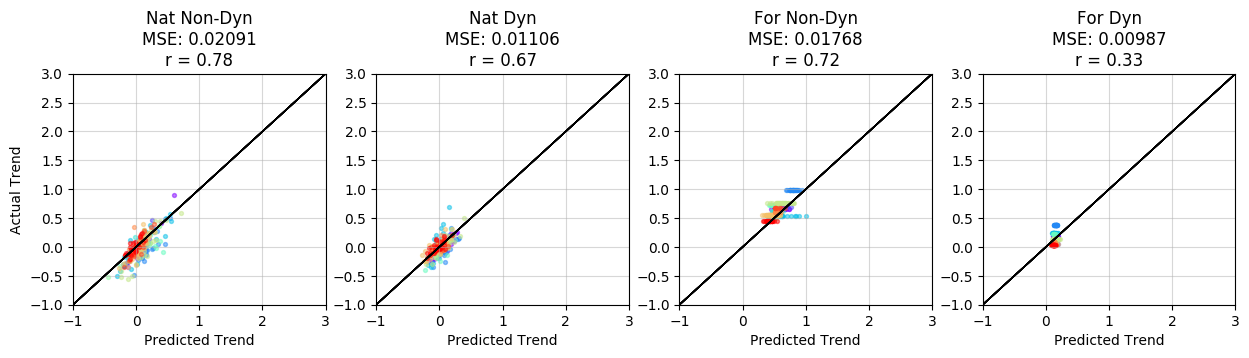

In [34]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1,4, figsize=(15,3))
titles = ['Nat Non-Dyn', 'Nat Dyn', 'For Non-Dyn', 'For Dyn']
colors = cm.rainbow(np.linspace(0, 1, 12))
all_preds_val = np.concatenate(preds_val, axis=1)
all_preds_val = np.swapaxes(all_preds_val, 0,1)
for mod in range(0, len(preds_val)):
    Y_preds, Y_test = preds_val[mod]
    for x in range(4):
        axs[x].plot(np.linspace(-5,5), np.linspace(-5,5), linewidth=1, color='black')
        axs[x].scatter(x=Y_preds[:,x], y=Y_test[:,x], s=8, color=colors[mod], alpha=0.5)
        axs[x].set_xlim(-1,3)
        axs[x].set_ylim(-1,3)
        mse = np.mean(np.square(all_preds_val[:,0,x] - all_preds_val[:,1,x]))
        r = stats.pearsonr(all_preds_val[:,0,x], all_preds_val[:,1,x])[0]
        axs[x].set_title(titles[x] + '\n' + 'MSE: ' + str(mse)[:7] + '\n' + 'r = ' + str(r)[:4])
        axs[x].grid(alpha=0.5)
        axs[x].set_xlabel('Predicted Trend')

axs[0].set_ylabel('Actual Trend')


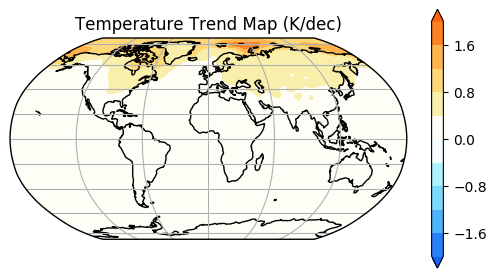

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap

colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)
ax = plt.axes(projection=ccrs.Robinson())

ax.set_global()

lons, lats, data = [np.linspace(0,360,144), np.linspace(-90,90,72), np.nanmean(maps[:,-1,:,:,0], axis=0)]

plt.contourf(lons, lats, data, transform=ccrs.PlateCarree(), cmap=custom_cmap, levels=np.linspace(-2,2,11), extend='both')
plt.colorbar(shrink=0.7)
ax.coastlines()
ax.gridlines()
ax.set_title('Temperature Trend Map (K/dec)')
plt.show()

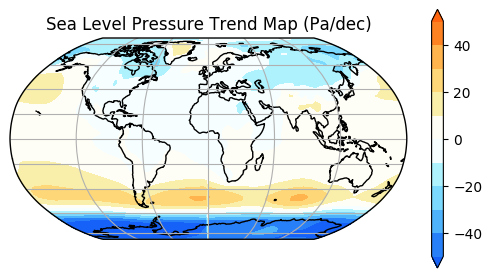

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap

colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)
ax = plt.axes(projection=ccrs.Robinson())

ax.set_global()

lons, lats, data = [np.linspace(0,360,144), np.linspace(-90,90,72), np.nanmean(maps[:,-1,:,:,1], axis=0)]

plt.contourf(lons, lats, data, transform=ccrs.PlateCarree(), cmap=custom_cmap, levels=np.linspace(-50,50,11), extend='both')
plt.colorbar(shrink=0.7)
ax.coastlines()
ax.gridlines()
ax.set_title('Sea Level Pressure Trend Map (Pa/dec)')
plt.show()